In [218]:
import math
import os
import tempfile
import mplcursors

import hdbscan
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering, \
    estimate_bandwidth, KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from kneed import KneeLocator
from read_clustering.variant_call import VariantCall
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from matplotlib.widgets import Cursor, Button
import bebi103
import bokeh
bokeh.io.output_notebook()

rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
sns.set()

Loading BokehJS ...

In [62]:
path = '/Users/shreyamantripragada/PycharmProjects/read_clustering/tests/test_files/native_cbf5_gal.csv'
data = pd.read_csv(path)

In [299]:
# !/usr/bin/env python
"""Variant call file class handler"""
########################################################################
# File: variant_call.py
#
#
# Author: Andrew Bailey, Shreya Mantripragada, Alejandra Duran, Abhay Padiyar
# History: 06/23/20 Created
########################################################################

import math
import os

import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, DBSCAN, MeanShift, SpectralClustering, \
    estimate_bandwidth, KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from kneed import KneeLocator

sns.set()


class VariantCall(object):
    """Read in variant call file and give access points to various types of data"""

    def __init__(self, file_path):
        """
        Initialize the class
        :param file_path: path to csv file
        """
        self.data = pd.read_csv(file_path)
        self.canonical = {"A", "C", "G", "T"}

    def get_read_ids(self):
        """Return the set of read ids """
        return set(self.data.read_id)

    def get_number_of_ids(self):
        """Return the number of read ids """
        return len(self.get_read_ids())

    def get_strands(self):
        """Return the set of strands in the dataset"""
        return set(self.data.strand)

    def get_number_of_strands(self):
        """Return the number strands in the dataset"""
        return len(self.get_strands())

    def get_variant_sets(self):
        """Return the set of all possible sets of variants"""
        temp_df = self.data[['variants']]
        temp_df = temp_df.drop_duplicates()
        return temp_df

    def get_number_of_variant_sets(self):
        """Return the number of possible sets of variants"""
        return len(self.get_variant_sets())

    def get_variant_set_data(self, variant_set):
        """Return the corresponding data with specific variant set
        :param variant_set: a single variant set from the data
        :return temp_df: a data frame containing the data from the passed variant set
        """
        temp_df = self.data.loc[self.data['variants'] == variant_set]

        return temp_df

    def get_positions_of_variant_set(self, variant_set):
        """Return the contig, strand and position of all locations of a variant set
        :param variant_set: a single variant set from the data
        :return temp_df: a data frame containing the 'contig', 'reference_index', and 'strand' of a given variant
        """
        temp_df = self.data[self.data['variants'] == variant_set]
        temp_df = temp_df[['contig', 'reference_index', 'strand', 'variants']]
        temp_df = temp_df.drop_duplicates()

        return temp_df

    def get_variant_sets_data(self, variant_sets):
        """Return the corresponding data with a list of variant sets
        :param variant_sets: a list of numerous variant sets from the data
        :return temp_df: a data frame containing the data of all the variant_sets in the list
        """

        temp_df = self.data[self.data['variants'].isin(variant_sets)]
        temp_df = temp_df.drop_duplicates()

        return temp_df

    def get_positions_of_variant_sets(self, variant_sets):
        """Return the contig, strand and position of all locations of a list of variant sets
        :param variant_sets: a list of numerous variant sets from the data
        :return temp_df: a data frame containing the 'contig', 'reference_index', and 'strand' of all the variant_sets
                          in the list
        """

        final_df = self.data[self.data['variants'].isin(variant_sets)]
        final_df = final_df[['contig', 'reference_index', 'strand', 'variants']]

        final_df = final_df.drop_duplicates()

        return final_df

    def get_read_data(self, read_id):
        """Return the corresponding data with specific read_id.
        :param read_id: identification code for one continuous nucleotide reading. Python type:str
        :return: data frame with all the corresponding data for the given read_id
        """
        df1 = self.data[self.data['read_id'] == read_id]
        return df1

    def get_read_positions(self, read_id):
        """Return the contig, strand and position of all locations covered by read
        :param read_id: identification code for one continuous nucleotide reading. Python type:str
        :return: data frame with the 'contig', 'strand', 'reference_index', and 'variants' information
        for the given read_id
        """
        df1 = self.data[self.data['read_id'] == read_id]
        return df1.loc[:, ['contig', 'strand', 'reference_index', 'variants']]

    def get_read_variant_data(self, read_id, variant):
        """Return the corresponding data with specific read_id and specific variant
        :param read_id: identification code for one continuous nucleotide reading. Python type:str
        :param variant: a single variant possibility for one nucleotide position. Python type: str
        :return: data frame with all the corresponding data for the given read_id and variant
        """
        df1 = self.get_read_data(read_id)
        return df1[df1.variants.str.contains(variant)]

    def get_read_variant_set_data(self, read_id, variant_set):
        """Return the corresponding data with specific read_id and specific variant set
        :param read_id: identification code for one continuous nucleotide reading. Python type:str
        :param variant_set: all variant possibilities (2 or 3) for one nucleotide position. Python type:str
        :return: data frame with all the corresponding data for the given read_id and variant_set
        """
        df1 = self.get_read_data(read_id)
        return df1[df1['variants'] == variant_set]

    def get_read_variants_data(self, read_id, variants):
        """Return the corresponding data with specific read_id and list of variants
        :param read_id: identification code for one continuous nucleotide reading. Python type:str
        :param variants: a list of single variant possibilities each for one different nucleotide position
        :return: data frame with all the corresponding data for the given read_id and variants
        """
        df1 = self.get_read_data(read_id)
        return df1[df1.variants.str.contains('|'.join(variants))]

    def get_read_variant_sets_data(self, read_id, variant_sets):
        """Return the corresponding data with specific read_id and list of variant sets
        :param read_id: identification code for one continuous nucleotide reading. Python type:str
        :param variant_sets:  a list of all variant possibilities for different nucleotide positions
        :return: data frame with all the corresponding data for the given read_id and variant_sets
        """
        df1 = self.get_read_data(read_id)
        return df1[df1['variants'].isin(variant_sets)]

    def find_duplicates(self, read_id):
        """"return any duplicated rows if present in data set of a given read_id
        :param read_id: identification code for one continuous nucleotide reading. Python type:str
        :return: True if duplicated rows are present, False if not
        """
        df1 = self.get_read_data(read_id)
        dup = df1[df1.duplicated()]
        if dup.empty:
            return False
        else:
            return True

    def get_number_of_variants(self):
        """Return the number of variants including canonical nucleotides"""
        pass

    def get_number_of_non_canonical_variants(self):
        """Return the number of variants NOT including canonical nucleotides"""
        pass

    def get_variant_data(self, variant):
        """Return the corresponding data with specific variant"""
        pass

    def get_variants_data(self, variants):
        """Return the corresponding data with list of variants"""
        pass

    def get_positions_of_variant(self, variant):
        """Return the contig, strand and position of all locations of a variant"""
        pass

    def get_number_of_positions(self, contig, strand):
        """Return the number of variant positions on the contig strand
        :param contig: string of contig
        :param strand: string of strand {"+","-"}
        :return: integer of number of positions
        """
        new_df = self.data[(self.data['contig'] == contig) & (self.data['strand'] == strand)]
        return len(set(new_df.reference_index))

    def get_position_data(self, contig, strand, position):
        """If position exists return all data covering that position otherwise return false
        :param contig: string of contig
        :param strand: string of strand {"+","-"}
        :param position: integer of reference position
        :return dataframe where contig, strand and reference_index match input parameters
        """
        data = self.data[(self.data['contig'] == contig) &
                         (self.data['strand'] == strand) &
                         (self.data['reference_index'] == position)]
        if data.empty:
            return False
        else:
            return data

    def get_positions_data(self, contigs, strands, positions):
        """If positions exists return all data covering those positions otherwise return false
        ex: get_positions_data(["a", "b"], ["+", "+"], [10, 120])
        :param contigs: list of strings of contigs
        :param strands: list of strings of strands {"+","-"}
        :param positions: list of integer of reference positions
        :return dataframe where contig, strand and reference_index match input parameters
        """
        assert len(contigs) == len(strands) == len(positions), "Must pass in equal number of contigs, strands, " \
                                                               "and positions. "

        return self._get_positions_data(pd.DataFrame({"contig": contigs,
                                                      "strand": strands,
                                                      "reference_index": positions}))

    def _get_positions_data(self, unique_df):
        """If positions exists return all data covering those positions otherwise return false
        ex: get_positions_data(pd.DataFrame({"contig": contigs, "strand": strands, "reference_index": positions}))
        :param unique_df: DataFrame with "contig", "strand", "reference_index" columns and no duplicate rows
        :return dataframe where contig, strand and reference_index are in the input dataframe
        """
        assert sum(unique_df.duplicated()) == 0, "There are duplicated rows in the passed in data frame"
        keys = list(unique_df.columns.values)
        i1 = unique_df.set_index(keys).index
        i2 = self.data.set_index(keys).index
        data = self.data[i2.isin(i1)]
        if data.empty:
            return False
        else:
            return data

    def get_variant_sets_from_position(self, contig, strand, position):
        """If position exists in read return variant sets
        :param contig: string of contig
        :param strand: string of strand {"+","-"}
        :param position: integer of reference position
        :return: set of all variant sets or False if position does not exist
        """
        data = self.get_position_data(contig, strand, position)
        if data is not False:
            return set(data["variants"])
        else:
            return data

    def get_variants_from_position(self, contig, strand, position):
        """If position exists return variants
        :param contig: string of contig
        :param strand: string of strand {"+","-"}
        :param position: integer of reference position
        :return: set of all variants or False if position does not exist
        """
        data = self.get_variant_sets_from_position(contig, strand, position)
        if data is not False:
            return set("".join(data))
        else:
            return False

    def get_read_position_data(self, read_id, position):
        """If position exists in read return data covering position
        :param read_id: string read name
        :param position: integer reference index
        :return: dataframe with both read_id equal to read_id and reference_index equal to position
        """
        data = self.data[(self.data['read_id'] == read_id) & (self.data['reference_index'] == position)]
        if data.empty:
            return False
        assert len(data) == 1, \
            "Check input file. Got multiple hits for read {} and position {}.".format(read_id, position)
        return data

    def get_read_positions_data(self, read_id, positions):
        """If position exists in read return data covering list of positions
        :param read_id: string read name
        :param positions: list of reference indices
        :return dataframe with both read_id equal to read_id and reference_index is in positions list
        """
        data = self.data[(self.data['read_id'] == read_id) & (self.data['reference_index'].isin(positions))]
        if data.empty:
            return False
        return data

    def get_contig_positions(self, contig):  # assumes there is at least one read that covers all positions
        data = self.data.loc[self.data['contig'] == contig]
        data_2 = data.groupby(['reference_index']).nunique()
        positions = []
        for i, row in data_2.iterrows():
            positions.append(i)
        return positions

    def get_reads_covering_positions_data(self, positions, plot=False):
        data = self.data[self.data['reference_index'].isin(positions)]
        plot_data = data.loc[:, ['read_id', 'reference_index', 'variants', 'prob1', 'prob2']]
        pos_n = len(positions)
        select = plot_data.groupby(['read_id']).nunique()
        select.rename(columns={'read_id': 'id_number'}, inplace=True)
        a = select[select['reference_index'] == pos_n]
        target_ids = list(a.index.values)
        d = {}
        for pos in positions:
            d[str(pos)] = []
        for i in target_ids:
            r = (plot_data.loc[plot_data['read_id'] == i]).set_index('reference_index')
            for index, row in r.iterrows():
                d[str(index)].append(r.at[index, 'prob2'])
        df_plot = pd.DataFrame(list(zip(target_ids)))
        df_plot.columns = ['read_id']
        for key in d:
            col_val = ''
            col_val += 'P' + ' ' + str(key)
            df_plot[col_val] = d[key]
        if plot:
            del df_plot['read_id']
        return df_plot

    # Spectral clustering

    def spectral_clusters(self, positions):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        dists = squareform(pdist(X.values))  # ndarray
        neighbor_n = int(math.sqrt(len(positions)))
        knn_distances = np.sort(dists, axis=0)[neighbor_n]  # indexer is usually sqrt(number_of_data_points)
        knn_distances = knn_distances[np.newaxis].T
        local_scale = knn_distances.dot(knn_distances.T)
        a_matrix = dists * dists
        a_matrix = -a_matrix / local_scale
        a_matrix[np.where(np.isnan(a_matrix))] = 0.0
        a_matrix = np.exp(a_matrix)
        np.fill_diagonal(a_matrix, 0)  # now have a_matrix
        A = a_matrix
        L = csgraph.laplacian(A, normed=True)
        n_components = A.shape[0]
        eigenvalues, eigenvectors = eigsh(L, k=n_components, which='LM', sigma=1.0, maxiter=500)
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.xlabel('K clusters')
        plt.ylabel('Eigengap')
        axes = plt.gca()
        axes.set_xlim([-5, 80])
        return plt.grid()

    def spectral_affinity(self, positions, n_clusters):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        spectral_model_rbf = SpectralClustering(n_clusters=n_clusters, affinity='rbf')  # with any value for n_clusters
        labels_rbf = spectral_model_rbf.fit_predict(X)
        spectral_model_nn = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors')
        labels_nn = spectral_model_nn.fit_predict(X)
        affinity = ['rbf', 'nearest_neighbors']
        s_scores = [metrics.silhouette_score(X, labels_rbf), metrics.silhouette_score(X, labels_nn)]
        plt.bar(affinity, s_scores)
        plt.xlabel('Affinity')
        plt.ylabel('Silhouette Score')
        plt.title('Comparison of different Clustering Models')
        return plt.show()

    def spectral_clustering(self, positions, n_clusters=1, affinity='x'):
        # needs n_clusters, affinity as **other_params
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return SpectralClustering(n_clusters=n_clusters, affinity=affinity).fit(X), SpectralClustering(
            n_clusters=n_clusters, affinity=affinity).fit_predict(X)

    # mean shift

    def mean_shift(self, positions, find_optimal=True):
        # need no **other_params
        X = self.get_reads_covering_positions_data(positions, plot=True)
        if find_optimal:
            quantile_data = X.to_numpy()
            quantile_val = np.quantile(quantile_data, 0.5)
            bandwidth = estimate_bandwidth(X, quantile=quantile_val)
        else:
            bandwidth = 0.5
        ms = MeanShift(bandwidth=bandwidth)
        mf = ms.fit(X)
        print('Number of clusters found: ', len(mf.cluster_centers_))
        return mf, ms.fit_predict(X)

    # K means

    def k_means_clusters(self, positions, max_number_clusters):
        X = get_reads_covering_positions_data(positions, plot=True)
        model = KMeans()
        visualizer = KElbowVisualizer(model, k=(1, max_number_clusters + 1))
        v = visualizer.fit(X)
        v.show()
        return v.elbow_value_

    def k_means(self, positions, find_optimal = True, max_number_clusters = 1):
        # needs max_number_clusters as **other_params
        X = get_reads_covering_positions_data(positions, plot=True)
        if find_optimal:
            n = k_means_clusters(self, positions, max_number_clusters)
        else:
            n = max_number_clusters
        return KMeans(n_clusters=n).fit(X), KMeans(n_clusters=n).fit_predict(X)

    # HDBSCAN

    def HDBSCAN(self, positions, cluster_size=1):
        # needs cluster_size as **other_params
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return hdbscan.HDBSCAN(min_cluster_size=cluster_size, gen_min_span_tree=True).fit(X), hdbscan.HDBSCAN(
            min_cluster_size=cluster_size, gen_min_span_tree=True).fit_predict(X)

    # DBSCAN

    def DBSCAN_eps(self, positions):
        X = self.get_reads_covering_positions_data(positions)
        del X['read_id']
        neigh = NearestNeighbors(n_neighbors=2)
        nbrs = neigh.fit(X)
        distances, indices = nbrs.kneighbors(X)
        distances = np.sort(distances, axis=0)
        distances = distances[:, 1]
        a = plt.plot(distances)
        plt.xlabel('Points')
        plt.ylabel('eps value')
        print(a)
        i = np.arange(len(distances))
        knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
        plt.figure()
        knee.plot_knee()
        plt.xlabel('Points')
        plt.ylabel('eps')
        print('Optimal eps value: ', distances[knee.knee])

    def DBSCAN(self, positions, eps=1, min_samples=1):
        # needs eps, min_samples as **other_params
        X = self.get_reads_covering_positions_data(positions, plot=True)
        X = StandardScaler().fit_transform(X)
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit(X).labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print('Estimated number of clusters: ', n_clusters_)
        return db.fit(X), db.fit_predict(X)

    # Agglomerative clustering

    def get_dendrogram(self, positions, y1=0, y2=0, y3=0, figure_path=None):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        hierarchy.dendrogram(hierarchy.linkage(X, method='single'), labels=list(X.index.values))
        left, right = plt.xlim()
        plt.hlines(y1, left, right, linestyles='dashed', label='y1')
        plt.hlines(y2, left, right, linestyles='dashed', label='y2')
        plt.hlines(y3, left, right, linestyles='dashed', label='y3')
        plt.ylabel('Euclidean Distance')
        plt.title('Dendrogram of subunit data')
        plt.text(right, y1, 'y1')
        plt.text(right, y2, 'y2')
        plt.text(right, y3, 'y3')
        if figure_path is not None:
            assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
            plt.savefig(figure_path)
        else:
            plt.show()
        return figure_path

    def agglomerative_clustering(self, positions, n_clusters=1):
        # needs n_clusters as **other_params
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return AgglomerativeClustering(n_clusters=n_clusters).fit(X), AgglomerativeClustering(
            n_clusters=n_clusters).fit_predict(X)

    # affinity propagation

    def affinity_propagation(self, positions):
        # needs no **other_params
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return AffinityPropagation().fit(X), AffinityPropagation().fit_predict(X)

    # Gaussian mixture models

    def SelBest(self, arr: list, X: int) -> list:
        dx = np.argsort(arr)[:X]
        return arr[dx]

    def silhouette_score(self, positions):
        X = self.get_reads_covering_positions_data(positions)
        del X['read_id']
        n_clusters = np.arange(2, 20)
        sils = []
        sils_err = []
        iterations = 20
        for n in n_clusters:
            tmp_sil = []
            for _ in range(iterations):
                gmm = GMM(n, n_init=2).fit(X)
                labels = gmm.predict(X)
                sil = metrics.silhouette_score(X, labels, metric='euclidean')
                tmp_sil.append(sil)
            val = np.mean(self.SelBest(list(tmp_sil), int(iterations / 5)))
            err = np.std(tmp_sil)
            sils.append(val)
            sils_err.append(err)
        plt.errorbar(n_clusters, sils, yerr=sils_err)
        plt.title("Silhouette Scores", fontsize=20)
        plt.xticks(n_clusters)
        plt.xlabel("N. of clusters")
        plt.ylabel("Score")
        return plt.show()

    def BIC(self, positions):
        X = self.get_reads_covering_positions_data(positions)
        del X['read_id']
        n_clusters = np.arange(2, 20)
        bics = []
        bics_err = []
        iterations = 20
        for n in n_clusters:
            tmp_bic = []
            for _ in range(iterations):
                gmm = GMM(n, n_init=2).fit(X)
                tmp_bic.append(gmm.bic(X))
            val = np.mean(self.SelBest(np.array(tmp_bic), int(iterations / 5)))
            err = np.std(tmp_bic)
            bics.append(val)
            bics_err.append(err)
        plt.errorbar(n_clusters, bics, yerr=bics_err, label='BIC')
        plt.title("BIC Scores", fontsize=20)
        plt.xticks(n_clusters)
        plt.xlabel("N. of clusters")
        plt.ylabel("Score")
        plt.legend()
        plt.show()

        plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
        plt.title("Gradient of BIC Scores", fontsize=20)
        plt.xticks(n_clusters)
        plt.xlabel("N. of clusters")
        plt.ylabel("grad(BIC)")
        plt.legend()

    def gaussian_mixture_models(self, positions, n_clusters=1):
        # needs n_clusters as **other_params
        X = self.get_reads_covering_positions_data(positions, plot=True)
        return GMM(n_components=n_clusters).fit(X), GMM(n_components=n_clusters).fit_predict(X)

    # plot

    def plot_tSNE_reads_covering_positions_data(self, positions, clustering_algorithm, figure_path=None,
                                                **other_params):
        # **other_params can be : n_clusters=,affinity=, max_number_clusters=, cluster_size=,eps=, min_samples=,
        # n_components=, find_optimal=,  according to what each clustering method requires
        #new_df = data.copy()
        X = self.get_reads_covering_positions_data(positions, plot=True)
        tsne = TSNE(n_components=2, random_state=0)
        tsne_results = tsne.fit_transform(X)
        method_to_call = getattr(self, clustering_algorithm)
        fit, predictor = method_to_call(positions, **other_params)
        tooltips = [('variant', '@variants'),
                    ('read_id', '@read_id'),
                    ('position', '@reference_index'),
                    ('prob1', '@prob1'),
                    ('prob2', '@prob2'),
                    ('prob3', '@prob3')]
        hover = bokeh.models.HoverTool(tooltips=tooltips)
        p = bokeh.plotting.figure(plot_width=650, plot_height=450, 
                          x_axis_label='t-SNE axis 1',
                          y_axis_label='t-SNE axis 2')
        p.add_tools(hover)
        keys = data.variants.unique()
        wanted_cols = ['read_id', 'contig', 'strand', 'reference_index', 'variants', 'prob1', 'prob2', 'prob3']
        temp_data = data[wanted_cols]
        new_data = pd.DataFrame(tsne_results, columns=['tsne1','tsne2'])
        new_data[wanted_cols] = temp_data[wanted_cols]
        self.data = new_data
        color_dict = {keys[0]: '#331832', keys[1]: '#694D75', keys[2]: '#1B5299', keys[3]: '#9FC2CC', keys[4]: '#F1ECCE', 
                     keys[5]: '#56A3A6', keys[6]: '#484538', keys[7]: '#CAD49D', keys[8]: '#D4EAC8', keys[9]: '#C0D8E0', 
                    keys[10]: '#F7C59F', keys[11]: '#2A324B', keys[12]: '#767B91'}
        for key, group in new_data.groupby('variants'):
            source = bokeh.models.ColumnDataSource(group)
            p.circle(x='tsne1', y='tsne2', size=7, alpha=0.5, source=source,
                 color=color_dict[key], legend_label=key)
        p.legend.background_fill_alpha = 0.25
        p.legend.location = 'bottom_right'
        p.legend.background_fill_color = 'blanchedalmond'
        if figure_path is not None:
            assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
            plt.savefig(figure_path)
        else:
            bokeh.io.show(p)
        return figure_path

    def plot_PCA_reads_covering_positions_data(self, positions, clustering_algorithm, figure_path=None, **other_params):
        X = self.get_reads_covering_positions_data(positions, plot=True)
        scaler = StandardScaler()
        scaler.fit(X)
        scaled_data = scaler.transform(X.values)
        pca = PCA(n_components=2)
        pca.fit(scaled_data)
        x_pca = pca.transform(scaled_data)
        method_to_call = getattr(self, clustering_algorithm)
        fit, predictor = method_to_call(positions, max_number_clusters=1)
        #plt.scatter(x_pca[:, 0], x_pca[:, 1], s=40)
        plt.scatter(x_pca[:, 0], x_pca[:, 1], c=predictor, s=40, cmap = 'rainbow')
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.title(str(len(positions)) + ' ' + 'positions' + ' ' + clustering_algorithm + ' ' + 'clustering')
        if figure_path is not None:
            assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
            plt.savefig(figure_path)
        else:
            plt.show()
        return figure_path

    def plot_number_reads_covering_positions(self, contig, figure_path=None, verbose=False):
        data = self.data.loc[self.data['contig'] == contig].set_index('reference_index')
        data_2 = data.loc[:, 'read_id']
        reads_dict = defaultdict(list)
        pos = []
        for index, value in data_2.items():
            reads_dict[str(index)].append(value)
            pos.append(index)
        positions = list(dict.fromkeys(pos))
        positions.reverse()
        n = 0
        d = {}
        for i in positions:
            n += 1
            if n == 1:
                comp = reads_dict[str(i)]
                d[str(i)] = len(comp)
            else:
                unique_val = set(reads_dict[str(i)]).intersection(comp)
                comp = list(unique_val)
                d[str(i)] = len(comp)
        count_reads = pd.Series(d)
        count_reads.plot(title='Reads for ' + contig, legend=False)
        number = count_reads.min()
        if verbose:
            print('Reads covering all positions in ' + str(contig) + ': ' + str(number))
        if figure_path is not None:
            assert not os.path.exists(figure_path), "Save fig path does exist: {}".format(figure_path)
            plt.savefig(figure_path)
        else:
            plt.show()
        return figure_path, number


In [300]:
var = VariantCall('/Users/shreyamantripragada/PycharmProjects/read_clustering/tests/test_files/native_cbf5_gal.csv')

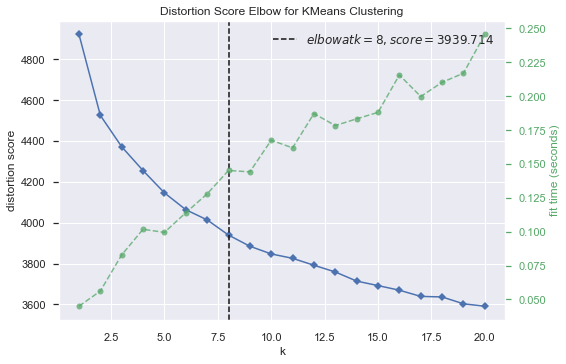

In [301]:
var.plot_tSNE_reads_covering_positions_data(var.get_contig_positions('RDN18-1'), 'k_means', max_number_clusters=20)  